In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, matthews_corrcoef
from statsmodels.stats.multitest import multipletests
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.colors import rgb_to_hsv 

In [3]:
## bay across plates 
phase1_df=pd.read_csv('phase1_qn_slopes(5.18).csv',low_memory=False)
cts_light = ['20h_HL', '20h_ML']
phase1_df['y2_slope_select'] = phase1_df.apply(
    lambda row: row['y2_slope'] if row['light_regime'] in cts_light else row['y2_slope_on'],
    axis=1
)
wt_df = phase1_df[phase1_df['mutant_ID'] == 'WT']
mutant_df = phase1_df[phase1_df['mutant_ID'] != 'WT']

## 20h_HL

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_gene_vs_wt_per_plate(
    wt_df,
    mutant_df,
    regime,
    expected_genes,
    title_suffix='',
    y_col='y2_slope_select',
    figsize=(10, 6),
    y_lim=None,
    gene_color_map=None,
):
    """
    Phase 1 version: plates 1–23, each mutant has one replicate.
    Plots WT vs selected genes per plate and appends grand means at the end.
    """

    # --- subset to the regime of interest ---
    wt_vals = wt_df[wt_df['light_regime'] == regime].copy()
    mutant_vals = mutant_df[
        (mutant_df['light_regime'] == regime) &
        (mutant_df['mutated_genes'].isin(expected_genes))
    ].copy()

    if wt_vals.empty or mutant_vals.empty:
        print(f"⚠️ No data for regime '{regime}' and expected genes.")
        return

    # --- ensure plate is string so ordering works cleanly ---
    wt_vals['plate'] = wt_vals['plate'].astype(str)
    mutant_vals['plate'] = mutant_vals['plate'].astype(str)

    # --- label column for hue ---
    wt_vals['label'] = 'WT'
    mutant_vals['label'] = mutant_vals['mutated_genes']
    combined = pd.concat([wt_vals, mutant_vals], ignore_index=True)

    # --- desired plate order for Phase 1 (1..23) that actually appear in data ---
    desired_order_all = [str(i) for i in range(1, 24)]
    plates_in_data = combined['plate'].unique().tolist()
    ordered_plates = [p for p in desired_order_all if p in plates_in_data]

    # --- append grand mean slots ---
    grand_mean_labels = ['WT_mean'] + [f"{gene}_mean" for gene in expected_genes]
    ordered_plates += grand_mean_labels

    # --- color map (WT + each gene) ---
    if gene_color_map is None:
        labels = ['WT'] + list(expected_genes)
        palette = sns.color_palette('Set1', n_colors=len(labels))
        gene_color_map = dict(zip(labels, palette))

    # --- plot: each observation is one point (single replicate per mutant) ---
    plt.figure(figsize=figsize)
    ax = sns.stripplot(
        data=combined,
        x='plate',
        y=y_col,
        hue='label',
        dodge=True,
        jitter=0.12,
        size=6,
        edgecolor='black',
        linewidth=0.4,
        palette=gene_color_map,
        order=ordered_plates,  # includes the grand-mean placeholders at the end
    )

    # --- add grand means (diamond markers) at the end ---
    grand_means = []
    wt_mean_val = wt_vals[y_col].mean()
    grand_means.append(('WT_mean', 'WT', wt_mean_val))

    for gene in expected_genes:
        g_vals = mutant_vals.loc[mutant_vals['mutated_genes'] == gene, y_col]
        if not g_vals.empty:
            grand_means.append((f"{gene}_mean", gene, g_vals.mean()))

    for plate_label, label, y_val in grand_means:
        x_pos = ordered_plates.index(plate_label)
        ax.scatter(
            x=x_pos,
            y=y_val,
            marker='D',
            s=120,
            color=gene_color_map.get(label, 'black'),
            edgecolor='black',
            linewidth=1.2,
            zorder=6
        )

    # --- formatting ---
    plt.title(f'WT vs Selected Genes in {regime} {title_suffix}')
    plt.ylabel(y_col.replace('_', ' '))
    plt.xlabel('Plate')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    if y_lim:
        plt.ylim(y_lim)

    # tighter legend
    h, l = ax.get_legend_handles_labels()
    # keep legend only for WT + genes (not the stripplot internal)
    uniq = dict(zip(l, h))
    ax.legend(uniq.values(), uniq.keys(), title='Group', frameon=True)

    plt.tight_layout()
    plt.show()


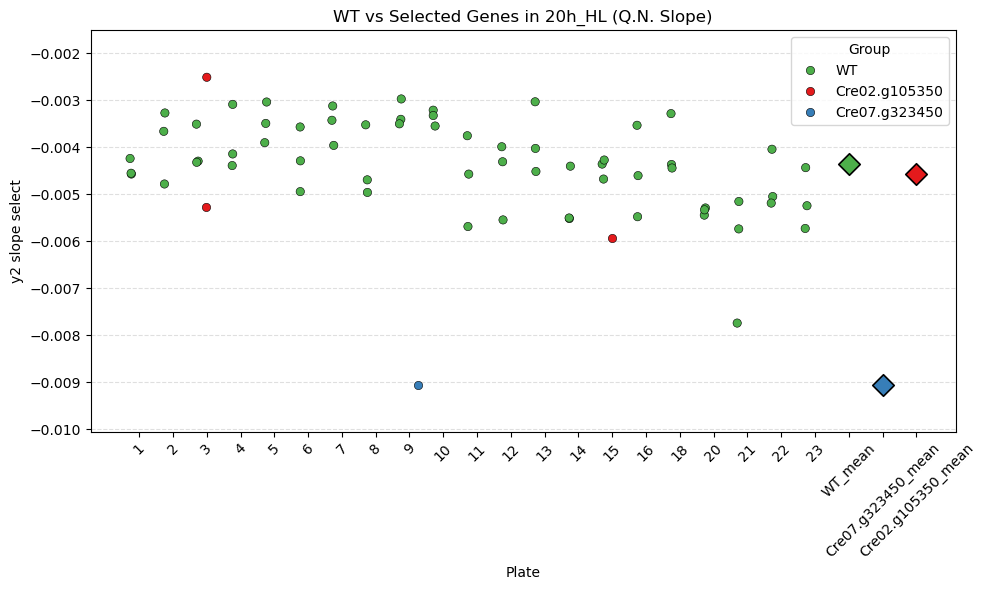

In [6]:
all_expected_genes = {'Cre02.g105350','Cre07.g323450','WT'}

colors = sns.color_palette('Set1', n_colors=len(all_expected_genes))
gene_color_map = dict(zip(sorted(all_expected_genes), colors))


regime = '20h_HL'
expected_genes = {'Cre02.g105350','Cre07.g323450','Cre13.g581900'}
wt_y_vals = wt_df[wt_df['light_regime'] == regime]['y2_slope_select']

mutant_y_vals = mutant_df[
    (mutant_df['light_regime'] == regime) &
    (mutant_df['mutated_genes'].isin(expected_genes))
]['y2_slope_select']

# Combine to compute axis limits
combined_y = pd.concat([wt_y_vals, mutant_y_vals])
y_min, y_max = combined_y.min(), combined_y.max()
y_lim = (y_min - 0.001, y_max + 0.001)


plot_gene_vs_wt_per_plate(
    wt_df=wt_df,
    mutant_df=mutant_df,
    regime='20h_HL',
    expected_genes={'Cre02.g105350','Cre07.g323450'},
    title_suffix='(Q.N. Slope)',
    gene_color_map=gene_color_map,
    y_lim=y_lim
)

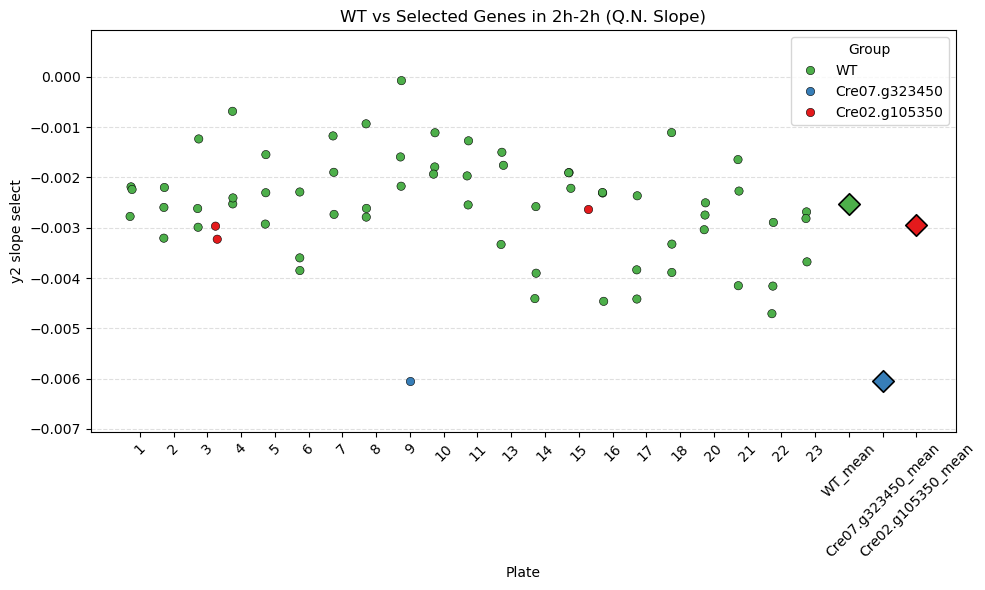

In [10]:
all_expected_genes = {'Cre02.g105350','Cre07.g323450','WT'}

colors = sns.color_palette('Set1', n_colors=len(all_expected_genes))
gene_color_map = dict(zip(sorted(all_expected_genes), colors))


regime = '2h-2h'
expected_genes = {'Cre02.g105350','Cre07.g323450','Cre13.g581900'}
wt_y_vals = wt_df[wt_df['light_regime'] == regime]['y2_slope_select']

mutant_y_vals = mutant_df[
    (mutant_df['light_regime'] == regime) &
    (mutant_df['mutated_genes'].isin(expected_genes))
]['y2_slope_select']

# Combine to compute axis limits
combined_y = pd.concat([wt_y_vals, mutant_y_vals])
y_min, y_max = combined_y.min(), combined_y.max()
y_lim = (y_min - 0.001, y_max + 0.001)


plot_gene_vs_wt_per_plate(
    wt_df=wt_df,
    mutant_df=mutant_df,
    regime='2h-2h',
    expected_genes={'Cre02.g105350','Cre07.g323450'},
    title_suffix='(Q.N. Slope)',
    gene_color_map=gene_color_map,
    y_lim=y_lim
)

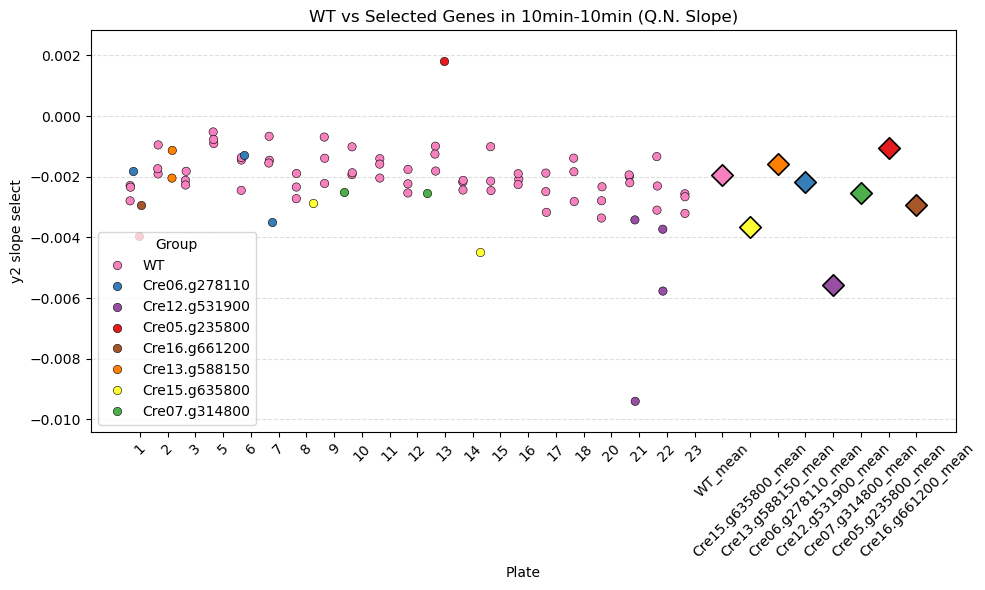

In [43]:
regime = '10min-10min'
expected_genes = {'Cre12.g531900','Cre16.g661200','Cre07.g314800','Cre13.g588150','Cre05.g235800','Cre15.g635800','Cre06.g278110','WT'}
wt_y_vals = wt_df[wt_df['light_regime'] == regime]['y2_slope_select']
colors = sns.color_palette('Set1', n_colors=len(expected_genes))
gene_color_map = dict(zip(sorted(expected_genes), colors))

mutant_y_vals = mutant_df[
    (mutant_df['light_regime'] == regime) &
    (mutant_df['mutated_genes'].isin(expected_genes))
]['y2_slope_select']

# Combine to compute axis limits
combined_y = pd.concat([wt_y_vals, mutant_y_vals])
y_min, y_max = combined_y.min(), combined_y.max()
y_lim = (y_min - 0.001, y_max + 0.001)


plot_gene_vs_wt_per_plate(
    wt_df=wt_df,
    mutant_df=mutant_df,
    regime='10min-10min',
    expected_genes={'Cre12.g531900', 'Cre16.g661200', 'Cre07.g314800', 'Cre13.g588150', 'Cre05.g235800','Cre15.g635800','Cre06.g278110'},
    title_suffix='(Q.N. Slope)',
    gene_color_map=gene_color_map,
    y_lim=y_lim
)

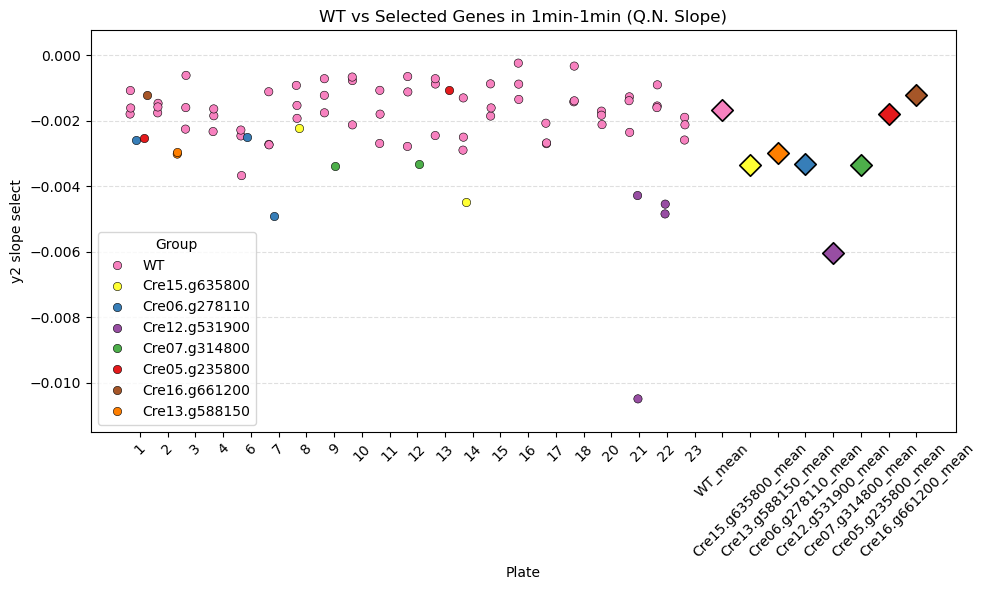

In [36]:
regime = '1min-1min'
expected_genes = {'Cre12.g531900','Cre16.g661200','Cre07.g314800','Cre13.g588150','Cre05.g235800','Cre15.g635800','Cre06.g278110','WT'}
wt_y_vals = wt_df[wt_df['light_regime'] == regime]['y2_slope_select']
colors = sns.color_palette('Set1', n_colors=len(expected_genes))
gene_color_map = dict(zip(sorted(expected_genes), colors))

mutant_y_vals = mutant_df[
    (mutant_df['light_regime'] == regime) &
    (mutant_df['mutated_genes'].isin(expected_genes))
]['y2_slope_select']

# Combine to compute axis limits
combined_y = pd.concat([wt_y_vals, mutant_y_vals])
y_min, y_max = combined_y.min(), combined_y.max()
y_lim = (y_min - 0.001, y_max + 0.001)


plot_gene_vs_wt_per_plate(
    wt_df=wt_df,
    mutant_df=mutant_df,
    regime='1min-1min',
    expected_genes={'Cre12.g531900', 'Cre16.g661200', 'Cre07.g314800', 'Cre13.g588150', 'Cre05.g235800','Cre15.g635800','Cre06.g278110'},
    title_suffix='(Q.N. Slope)',
    gene_color_map=gene_color_map,
    y_lim=y_lim
)

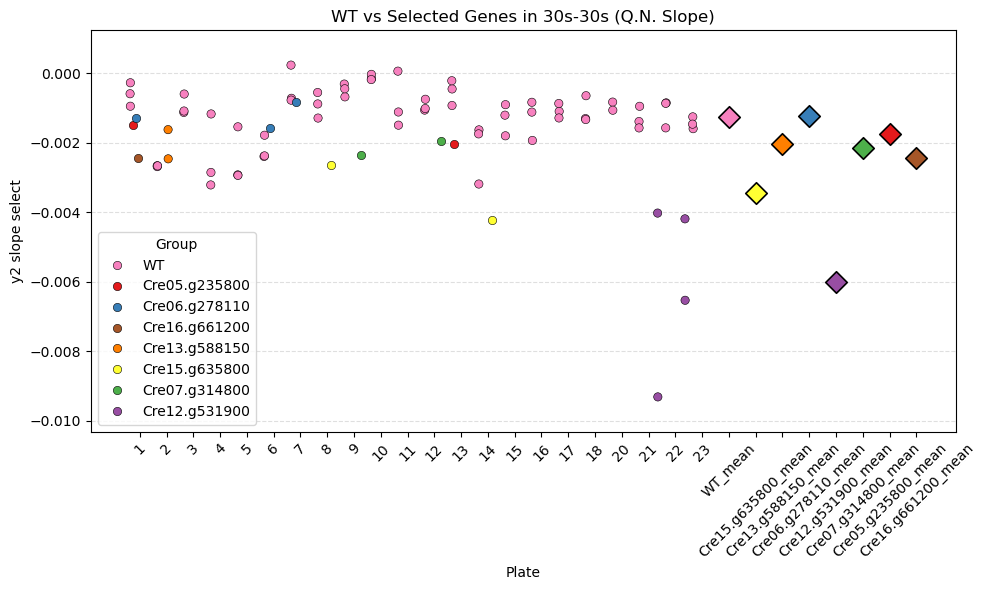

In [38]:
regime = '30s-30s'
expected_genes = {'Cre12.g531900','Cre16.g661200','Cre07.g314800','Cre13.g588150','Cre05.g235800','Cre15.g635800','Cre06.g278110','WT'}
wt_y_vals = wt_df[wt_df['light_regime'] == regime]['y2_slope_select']
colors = sns.color_palette('Set1', n_colors=len(expected_genes))
gene_color_map = dict(zip(sorted(expected_genes), colors))

mutant_y_vals = mutant_df[
    (mutant_df['light_regime'] == regime) &
    (mutant_df['mutated_genes'].isin(expected_genes))
]['y2_slope_select']

# Combine to compute axis limits
combined_y = pd.concat([wt_y_vals, mutant_y_vals])
y_min, y_max = combined_y.min(), combined_y.max()
y_lim = (y_min - 0.001, y_max + 0.001)


plot_gene_vs_wt_per_plate(
    wt_df=wt_df,
    mutant_df=mutant_df,
    regime='30s-30s',
    expected_genes={'Cre12.g531900', 'Cre16.g661200', 'Cre07.g314800', 'Cre13.g588150', 'Cre05.g235800','Cre15.g635800','Cre06.g278110'},
    title_suffix='(Q.N. Slope)',
    gene_color_map=gene_color_map,
    y_lim=y_lim
)